In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Part 1

First we generate an index of the sequence we are aligning to.
> bowtie2-build chr19.fa chr19

Then we mapped each set of reads against the reference genome. (I tried to format this correctly but the markdown in jupyter was doing weird things so I took the dollar signs out from before the brackets so it would show correctish...)
> for sample in CTCF_ER4 CTCF_G1E input_ER4 input_G1E; do; bowtie2 -x chr19 -U {sample}.fastq -S {sample}.sam -p 6 ;samtools view -bSo {sample}.bam  {sample}.sam; samtools sort {sample}.bam {sample}.sorted; samtools index {sample}.sorted.bam; done


Then we called the peaks using macs2 for both ER4 and G1E.
> macs2 callpeak -t CTCF_ER4.bam -c input_ER4.bam --format=BAM --name=CTCF_ER4 --gsize=61000000 --tsize=36

> macs2 callpeak -t CTCF_G1E.bam -c input_G1E.bam --format=BAM --name=CTCF_G1E --gsize=61000000 --tsize=36

To idenfiy locations where CTCF binding was lost or gained we used bedtools interset with -v flag.
> bedtools intersect -a CTCF_G1E_peaks.narrowPeak -b CTCF_ER4_peaks.narrowPeak -v > loss_features.bed

> bedtools intersect -a CTCF_ER4_peaks.narrowPeak -b CTCF_G1E_peaks.narrowPeak -v > gained_features.bed

To identify feature overlap we used bedtools interest.
> bedtools intersect -a Mus_musculus.GRCm38.94_features.bed -b CTCF_G1E_peaks.narrowPeak > feature_overlapG1E.bed

> bedtools intersect -a Mus_musculus.GRCm38.94_features.bed -b CTCF_ER4_peaks.narrowPeak > feature_overlapER4.bed

To count the number of CTCF binding sites in G1E and ER4 overlap with each feature:
> cut -f 4 feature_overlapG1E.bed | sort | uniq -c > featuresG1E.txt

> cut -f 4 feature_overlapER4.bed | sort | uniq -c > featuresER4.txt

To determine the number of sites lost and gained for ER4. Flip the numbers for G1E.
> wc -l loss_features.bed > loss_gain.txt

> wc -l gained_features.bed >> loss_gain.txt 


In [60]:
# create merged dataframe for plotting 
ER4 = pd.read_csv("featuresER4.txt", sep = "\s+" , names = ["ER4", "location"] )
G1E = pd.read_csv("featuresG1E.txt", sep = "\s+", names = ["G1E", "location"])
ER4_G1E = pd.merge(ER4, G1E, on = "location")
ER4_G1E

,ER4,location,G1E
0,101,exon,84
1,341,intron,307
2,67,promoter,54


In [54]:
# create DF for plotting based on loss_gain.txt file
lg = pd.read_csv("loss_gain.txt", sep = "\s+", header = None)
lg
lg_features = {"ER4": [57, 124],
               "G1E": [124, 57],
               "lg": ["loss", "gain"]}
lg_features = pd.DataFrame.from_dict(lg_features)
lg_features

,ER4,G1E,lg
0,57,124,loss
1,124,57,gain


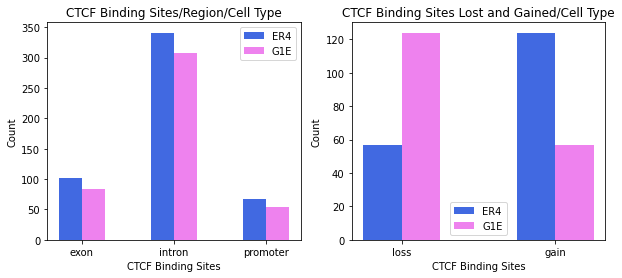

In [61]:
# plot for part 1
fig, ax = plt.subplots(ncols = 2)
fig.set_figwidth(10)
ax[0].bar(ER4_G1E.index - 0.25/2, ER4_G1E["ER4"], color = "royalblue", width = 0.25, label = "ER4")
ax[0].bar(ER4_G1E.index + 0.25/2, ER4_G1E["G1E"], color = "violet", width = 0.25, label = "G1E")
ax[0].set_title("CTCF Binding Sites/Region/Cell Type")
ax[0].set_xlabel("CTCF Binding Sites")
ax[0].set_ylabel("Count")
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(["exon", "intron", "promoter"])
ax[0].legend()

ax[1].bar(lg_features.index - 0.25/2, lg_features["ER4"], color = "royalblue", width = 0.25, label = "ER4")
ax[1].bar(lg_features.index + 0.25/2, lg_features["G1E"], color = "violet", width = 0.25, label = "G1E")
ax[1].set_title("CTCF Binding Sites Lost and Gained/Cell Type")
ax[1].set_xlabel("CTCF Binding Sites")
ax[1].set_ylabel("Count")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["loss", "gain"])
ax[1].legend()



# Part 2

First need to sort the file by the p-values (since they are in log10 format we want the greatest 100 values) which are in column 8 and then take the 100 top values into a file.
> sort -g -r -k 8 CTCF_ER4_peaks.narrowPeak | head -n 100 > top100_ER4.narrowPeak


Then we need a fasta file to input into meme-chip so we use bedtools to convert the start-stop numbers in the bed file to fasta file based on chromosome 19.
> bedtools getfasta -fi chr19.fa -bed top100_ER4.narrowPeak -fo top100_ER4.fasta

Finally we run the meme-chip command considering motifs up to 20bp long using the JASPAR_CORE_2019 database.
> meme-chip -meme-maxw 20 -db motif_databases/JASPAR/JASPAR_CORE_2016.meme top100_ER4.fasta

The output directory had three logo files in it, and logo1.png had the smallest E-value 2.9e-201 which means it was the most significant and therefore strongest motif. The logo1.png was pushed to github separately.